# Computer Assignment 2 - Naive Bayes Classifier

## Phase 1: Preprocess

In [59]:
from __future__ import unicode_literals
from hazm import *
import pandas as pd

In [60]:
df = pd.read_csv('divar_train.csv')
df.head()

,title,description,categories
0,بلبل خرمایی,سه عدد بلبل خرمایی سه ماهه.از وقتی جوجه بودن خ...,leisure-hobbies
1,عینک اسکی در حد,عینک اسکی دبل لنز مارک يو وكس در حد نو اصلی م...,leisure-hobbies
2,تکیه سر تویوتا پرادو,پارچه ای سالم و تمیز.,vehicles
3,مجسمه کریستال24%,مجسمه دکوری کریستال بالرین Rcr24%,for-the-home
4,کیف و ساک,هر 2 کاملا تمیز هستند,personal


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        10200 non-null  object
 1   description  10200 non-null  object
 2   categories   10200 non-null  object
dtypes: object(3)
memory usage: 239.2+ KB


Here we define stop words to help exclude stop words from text.

In [62]:
STOP_WORDS = ['از','که','با','به','برای','را','تا','اگه','اگر','اما','در', 'و', 'هر']

We Also make use of stemmer and lemmatizer to make words simpler by making plulral words singular and get the root of each verb respectively

In [63]:
stemmer = Stemmer()
lemmatizer = Lemmatizer()
def normalization(s):
    words = word_tokenize(s)
    words = list(filter(lambda word: word not in STOP_WORDS and len(word) > 1, words))
    for index, word in enumerate(words):
        words[index] = stemmer.stem(word)
        words[index] = lemmatizer.lemmatize(word)
    return words

df['description'] = df['description'].apply(normalization)
df['title'] = df['title'].apply(normalization)

getting categoriy names

In [64]:
categories = list(set(df['categories']))
categories

['leisure-hobbies',
 'for-the-home',
 'businesses',
 'electronic-devices',
 'vehicles',
 'personal']

## Phase 2: problem procedure

We reduce description and title columns into one column and tokenize its words and then map it into its token count like we have token_to_count map.

We also have category_to_frequency map which maps categories into their token_to_count mapping.

In [65]:
import collections

category_to_frequency_map = {c:0 for c in categories}
def mapping(df):
    tokens = []
    for token in list(df['description'].values):
        tokens += token
    for token in list(df['title'].values):
        tokens += token 
    lst = tokens
    token_to_count_map = dict(collections.Counter(lst))
    category_name = df.iloc[0]['categories']
    category_to_frequency_map[category_name] = token_to_count_map
    

df.groupby('categories').apply(mapping)

""


**Predictor Prior Probability** <br>
$p(x)$ : probability of seeing a word

**Class Prior Probability** <br>
$p(c)$ : probability of seeing a word with category c

**Posterior** <br>
$P(c|x) :$ probability of seeing category c by knowing that x is in there.

**likelihood** <br>
Here we calculate probability of occurance of each token in its category which is $P(x|c)$ 

In [66]:
import copy 
category_to_frequency_map_prob = copy.deepcopy(category_to_frequency_map)
for category in category_to_frequency_map_prob:
    token_to_count_map = copy.deepcopy(category_to_frequency_map[category])
    category_tokens_total = sum(token_to_count_map.values())
    for token in token_to_count_map:
        token_to_count_map[token] /= category_tokens_total 
    category_to_frequency_map_prob[category] = token_to_count_map


#### Bigrams Q3

یک لیوان شیر

شیر جنگل

in this example bigram is enough as livan and jangal won't come together most probably.

### Calculating Additive Smoothing probability

In [67]:
category_to_frequency_map_prob_ad = copy.deepcopy(category_to_frequency_map)
for category in category_to_frequency_map_prob_ad:
    token_to_count_map = copy.deepcopy(category_to_frequency_map[category])
    category_tokens_total = sum(token_to_count_map.values())
    for token in token_to_count_map:
        token_to_count_map[token] = (token_to_count_map[token] + 1) / (category_tokens_total + len(token_to_count_map) + 1)
    category_to_frequency_map_prob_ad[category] = token_to_count_map


### Baresi Sehat

In [68]:
import matplotlib.pyplot as plt
sorted_token_to_count = {c:0 for c in categories}
for category in category_to_frequency_map:
    token_to_count_map = category_to_frequency_map[category]
    sorted_token_to_count[category] = dict(sorted(token_to_count_map.items(), key=lambda item: item[1], reverse=True))


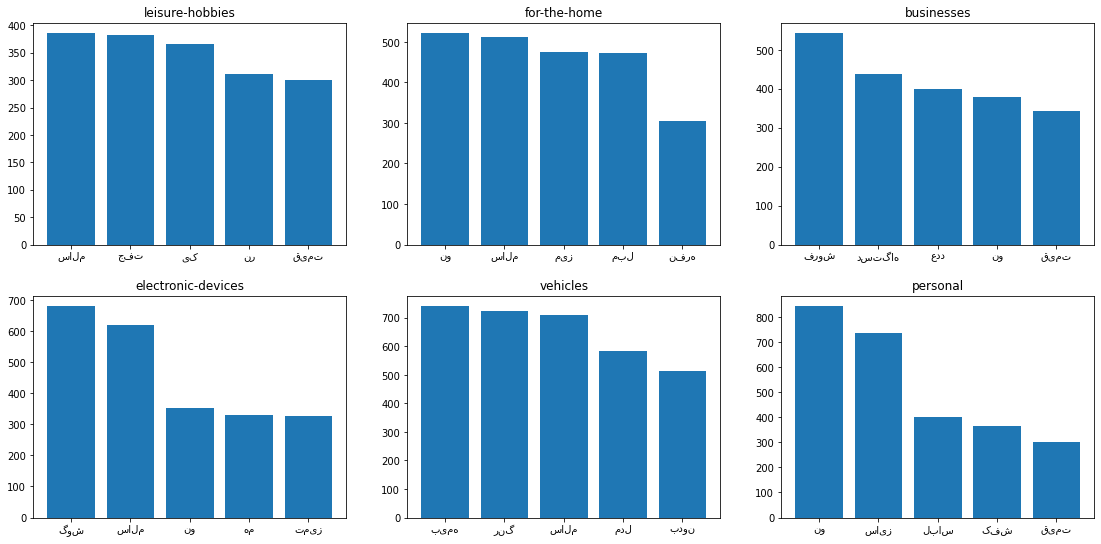

In [69]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16, 8)
fig.tight_layout(pad=3.0)

for i, key in enumerate(sorted_token_to_count):
    token_to_count = sorted_token_to_count[key]
    axs[int(i/3)][int(i%3)].set_title(key)
    axs[int(i/3)][int(i%3)].bar(
        list(token_to_count.keys())[0:5],
        list(token_to_count.values())[0:5]
    )

plt.show()

### Phase 3:  Evaluation

In [70]:
df_test = pd.read_csv('divar_test.csv')
df_test

,title,description,categories
0,کیف مجلسی نو,کیف مجلسی نوی نو,personal
1,دیوار کوب نمدی تزیینی,مناسب برای جهاز عروس,for-the-home
2,دو تیکه بسیار بسیار تمیز و سالم,با کشوی مخفی و شیک,for-the-home
3,مودم,سلام مودم سالم با وسایلش،دیگه ب کارم نمیاد \nم...,electronic-devices
4,تعداد18عددبوقلمون به قیمت عمده,سلام تعدای بوقلمون دارم به علت جابه جایی به فر...,leisure-hobbies
...,...,...,...
1795,باسکول 300کیلویی,سالمه سالمه بشرط\nقیمت نوش داخل بازار600تومنه,businesses
1796,میز مدیریتی با کنفرانس,میز مدیریتی با کنفرانس \nتمیز سالم بدون خط و خش,businesses
1797,باند aiwa,سالم،با اسپیکر,electronic-devices
1798,عروس هلندی مولد,پنج تا عروس هلندی، دو جفت ویک تک،یه جفتش دم ت...,leisure-hobbies


In [71]:
df_test['description'] = df_test['description'].apply(normalization)
df_test['title'] = df_test['title'].apply(normalization)



Q10)

### Not Additivie Smoothing

In [72]:
import math
p_c = {c:df_test.groupby('categories').size()[c]/len(df_test.index) for c in categories}
def classifier(words):
    likelihood = {}
    for category, c_probability in p_c.items():
        prob = math.log(c_probability)
        for word in words:
            if word not in category_to_frequency_map_prob[category]:
                prob = float(-math.inf)
                break
            prob += math.log(category_to_frequency_map_prob[category][word])
        likelihood[category] = prob
    return max(likelihood, key = likelihood.get)


In [73]:
count = 0
for row in df_test.iloc:
    words = row['title'] + row['description']
    if classifier(words) == row['categories']:
        count += 1
print("Accuracy: ", count / df_test.shape[0])


Accuracy:  0.4027777777777778


In [74]:
tp = {c:0 for c in categories}
fp = {c:0 for c in categories}
fn = {c:0 for c in categories}
for row in df_test.iloc:
    words = row['title'] + row['description']
    target_category = row['categories']
    detect = classifier(words)
    if detect == target_category:
        tp[target_category] += 1
    else:
        fp[detect] += 1
        fn[target_category] += 1


for category in categories:
    precision = tp[category] / (tp[category] + fp[category])
    recall = tp[category] / (tp[category] + fn[category])
    f1 = (2 * precision * recall) / (precision + recall)
    print("**Results for ", category, "**")
    print("True Positive for", category, tp[category])
    print("False Positive for", category, fp[category])
    print("False Negative for", category, fn[category])
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)
    print()

**Results for  leisure-hobbies **
True Positive for leisure-hobbies 294
False Positive for leisure-hobbies 1010
False Negative for leisure-hobbies 6
Precision: 0.2254601226993865
Recall: 0.98
F1: 0.3665835411471322

**Results for  for-the-home **
True Positive for for-the-home 111
False Positive for for-the-home 18
False Negative for for-the-home 189
Precision: 0.8604651162790697
Recall: 0.37
F1: 0.5174825174825175

**Results for  businesses **
True Positive for businesses 85
False Positive for businesses 26
False Negative for businesses 215
Precision: 0.7657657657657657
Recall: 0.2833333333333333
F1: 0.413625304136253

**Results for  electronic-devices **
True Positive for electronic-devices 54
False Positive for electronic-devices 7
False Negative for electronic-devices 246
Precision: 0.8852459016393442
Recall: 0.18
F1: 0.29916897506925205

**Results for  vehicles **
True Positive for vehicles 83
False Positive for vehicles 5
False Negative for vehicles 217
Precision: 0.9431818181818

### Additivie Smoothing

In [75]:
def additive_classifier(words):
    likelihood = {}
    for category, c_probability in p_c.items():
        category_tokens_total = sum(category_to_frequency_map[category].values())

        prob = math.log(c_probability)
        for word in words:
            if word not in category_to_frequency_map_prob_ad[category]:
                prob += math.log(1 / (category_tokens_total + len(token_to_count_map) + 1))
            else:
                prob += math.log(category_to_frequency_map_prob_ad[category][word])
        likelihood[category] = prob
    return max(likelihood, key = likelihood.get)

In [76]:
count = 0
for row in df_test.iloc:
    words = row['title'] + row['description']
    if additive_classifier(words) == row['categories']:
        count += 1
print("Accuracy: ", count / df_test.shape[0])

Accuracy:  0.8644444444444445


In [77]:
tp = {c:0 for c in categories}
fp = {c:0 for c in categories}
fn = {c:0 for c in categories}
wrong = []
wrong_c = []
for row in df_test.iloc:
    words = row['title'] + row['description']
    target_category = row['categories']
    detect = additive_classifier(words)
    if detect == target_category:
        tp[target_category] += 1
    else:
        fp[detect] += 1
        fn[target_category] += 1

        wrong.append(row)
        wrong_c.append(detect)


for category in categories:
    precision = tp[category] / (tp[category] + fp[category])
    recall = tp[category] / (tp[category] + fn[category])
    f1 = (2 * precision * recall) / (precision + recall)
    print("**Results for ", category, "**")
    print("True Positive for", category, tp[category])
    print("False Positive for", category, fp[category])
    print("False Negative for", category, fn[category])
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)
    print()
        

**Results for  leisure-hobbies **
True Positive for leisure-hobbies 248
False Positive for leisure-hobbies 22
False Negative for leisure-hobbies 52
Precision: 0.9185185185185185
Recall: 0.8266666666666667
F1: 0.8701754385964913

**Results for  for-the-home **
True Positive for for-the-home 270
False Positive for for-the-home 81
False Negative for for-the-home 30
Precision: 0.7692307692307693
Recall: 0.9
F1: 0.8294930875576038

**Results for  businesses **
True Positive for businesses 232
False Positive for businesses 62
False Negative for businesses 68
Precision: 0.7891156462585034
Recall: 0.7733333333333333
F1: 0.7811447811447811

**Results for  electronic-devices **
True Positive for electronic-devices 270
False Positive for electronic-devices 25
False Negative for electronic-devices 30
Precision: 0.9152542372881356
Recall: 0.9
F1: 0.9075630252100839

**Results for  vehicles **
True Positive for vehicles 267
False Positive for vehicles 14
False Negative for vehicles 33
Precision: 0.9

Q7) if the model guess any test case category the same then one of precision becomes 100%, this also true for recall

Q8) this score takes both FT and FN into account thus more useful than accuracy when you don't have an even class distribution

Q9) 

**Micro**: computes f1 by value total true positives, false negatives and false positives

**Macro**: computess f1 for each label, and returns the average without considering the proportion for each label in the dataset.

**Weighted**: computes f1 for each label, and returns the average considering the proportion for each label in the dataset.

Q11) Additive results is way better than normal

In [78]:
precision = 0
recall = 0
f1 = 0
for category in categories:
    p = tp[category] / (tp[category] + fp[category])
    precision += p
    r = tp[category] / (tp[category] + fn[category])
    recall += r
    f1 += (2 * p * r) / (p + r)

print("Macro Average Precision: ", precision/6)
print("Macro Average recall: ", recall/6)
print("Macro Average f1: ", f1/6)

Macro Average Precision:  0.8688078781752142
Macro Average recall:  0.8644444444444445
Macro Average f1:  0.8651494598404468


### Micro Average With Additive Smoothing:

$$Precision = \frac{TP_1 + TP_2 + TP_3 + TP_4 + TP_5 + TP_6}{TP_1 + FP_1 + TP_2 + FP_2 + TP_3 + FP_3 + TP_4 + FP_4 + TP_5 + FP_5 + TP_6 + FP_6}$$


In [79]:
precision = sum(tp.values())/(sum(fp.values())+sum(tp.values()))
print("Micro Average Precision: ", precision)

Micro Average Precision:  0.8644444444444445


$$Recall = \frac{TP_1 + TP_2 + TP_3 + TP_4 + TP_5 + TP_6}{TP_1 + FN_1 + TP_2 + FN_2 + TP_3 + FN_3 + TP_4 + FN_4 + TP_5 + FN_5 + TP_6 + FN_6}$$



In [80]:
recall = sum(tp.values())/(sum(fp.values())+sum(tp.values()))
print("Micro Average Recall: ", recall)

Micro Average Recall:  0.8644444444444445


$$ F_1 = 2\frac{Precision.Recall}{Precision + Recall} $$

In [81]:
print("Micro Average F1: ", (2 * precision * recall)/(precision + recall))

Micro Average F1:  0.8644444444444445


### Weighted Average With Additive Smoothing:

Because the number of samples of each category in the test dataset is the same so the Weighted average will be exactly the same as Macro average.

Q12)

In [85]:
wrong[0:5]

[title                                                 [سیپوراکس]
 description    [سیپوراکس, میکرو, مک, جی, بی, ال, سرامیک, سرا,...
 categories                                       leisure-hobbies
 Name: 16, dtype: object,
 title                                      [موتور, تزیین]
 description    [جنس, اهن, کار, دست, عرضه, صورت, عمده, تک]
 categories                                   for-the-home
 Name: 28, dtype: object,
 title          [90, عدد, بشقاب, پیتزا, تک, نفره, قیمت, هرعدد,...
 description    [بشقاب, پیتزا, یک, نفره, عدد, 4000, باتشکراز, ...
 categories                                            businesses
 Name: 37, dtype: object,
 title                        [اچارشلاقی, HEYCOالمان]
 description    [اصل, المان, سایز, ۱/۵, بسیار, مقاوم]
 categories                                businesses
 Name: 49, dtype: object,
 title                                    [فروش, تلفکس]
 description    [سلام, تلفکس, پاناسونیک, تمیز, کم, کار]
 categories                                  busi

In [84]:
collections.Counter(wrong_c)

Counter({'for-the-home': 81,
         'businesses': 62,
         'personal': 40,
         'electronic-devices': 25,
         'leisure-hobbies': 22,
         'vehicles': 14})

this happened because in some of these samples have words that got wrong with other words for other categories